In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn
import pickle
import seaborn as sns

from model_evaluation import metrics_regression, test_different_models, print_scoretable

from train_test_split import train_test_split_as_requested

from sklearn import linear_model
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# RANDOM_STATE = 42
# TRAINING_PORTITION = .8

Tarjoaa funktiot:
- testDifferentClassifiers(X_train, X_test, y_train, y_test, modelsToTest, average_type='binary')
- print_scoretable(scores, columns=['Accuracy', 'AUC', 'MCC', 'Precision', 'Recall'])  tulostaa DataFramen tyyliteltynä niin, että tekstin taustalla on palkit 
- draw_confusion_matrix_for_good_poor(truevalues, predictions, normalize=True, title=)  piirtää confusionmatrixin oletuksella, että 1/true = good, 0/false = poor
- drawWordCloud(words, title, numberofWords = 100, color='blue', titlefontsize=12)   värivaihtoehdot red, green, blue
- draw_roc_curve(fpr, tpr)  piirtää ROC-kuvaajan perustuen sklearn.metrics.roc_curve -funktion tuloksiin
- plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))


## Getting data from pickle files dumped in notebook 1

In [2]:
with open("random_reviews.p","rb") as f:
    random_reviews = pickle.load( f )

with open("bow1000.p","rb") as f:
    bow1000 = pickle.load( f )

### Split the array into a training and test sets: 800 first rows for the training set and 200 last rows for testing.

In [3]:
train_data, test_data = bow1000.head(800), bow1000.tail( len(bow1000) - 800)

test_data.describe()

,able,absolutely,accommodating,across,actually,add,added,additional,advice,afternoon,...,writing,wrong,year,years,yelp,yes,yet,young,yum,yummy
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.040000,0.040000,0.010000,0.015000,0.055000,0.005000,0.005000,0.005000,0.020000,0.030000,...,0.0,0.045000,0.015000,0.050000,0.030000,0.020000,0.020000,0.025000,0.015000,0.035000
std,0.196451,0.220552,0.099748,0.121857,0.249572,0.070711,0.070711,0.070711,0.172478,0.171015,...,0.0,0.207824,0.121857,0.218492,0.222141,0.140351,0.140351,0.156517,0.157796,0.184241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000


In [4]:
train_data.describe()

,able,absolutely,accommodating,across,actually,add,added,additional,advice,afternoon,...,writing,wrong,year,years,yelp,yes,yet,young,yum,yummy
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.035000,0.038750,0.010000,0.017500,0.038750,0.020000,0.022500,0.011250,0.007500,0.012500,...,0.012500,0.035000,0.040000,0.068750,0.033750,0.025000,0.026250,0.011250,0.011250,0.025000
std,0.183895,0.193119,0.099561,0.131207,0.205673,0.140088,0.156603,0.105534,0.086331,0.121911,...,0.121911,0.215251,0.220138,0.281287,0.245329,0.164039,0.159978,0.116793,0.116793,0.185521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,3.000000


### fit (learn) a model on the training set by using features (BoW and other features such as funny) to predict the label (“useful" column). Then use the fitted model to predict the “useful" for the test set. Try one or two regression method(s), use plots to show your results. Observe and analyze methods and results.


In [5]:
# Combining two dataframes to one
joined_df = pd.concat([random_reviews.add_prefix("random_reviews_"),bow1000], axis=1)

# Checking number of NaN - no columns with NaN
s = joined_df.isna().sum()
print("Columns with non-zero number of nan: ",s[s != 0])

Columns with non-zero number of nan:  Series([], dtype: int64)


In [6]:
# Splitting to training and test and separating predictors from labels
features, labels = joined_df.drop(['random_reviews_useful','random_reviews_business_id','random_reviews_review_id','random_reviews_text','random_reviews_user_id','random_reviews_date'], axis=1), joined_df['random_reviews_useful']






In [7]:
features.head(10)

,random_reviews_cool,random_reviews_funny,random_reviews_stars,random_reviews_category,able,absolutely,accommodating,across,actually,add,...,writing,wrong,year,years,yelp,yes,yet,young,yum,yummy
0,0,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,4,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
modelsToTest=[
  ("LinearRegression", sklearn.linear_model.LinearRegression(), 0.5),
  ("SVM regressor - linear", LinearSVR(max_iter=-1)), 
  ("SVM regressor - RBF kernel", SVR(kernel='rbf', max_iter=-1)),
  ("DecisionTreeRegressor", DecisionTreeRegressor(max_depth=10,min_samples_split=20)),
  ("RandomForestRegressor",RandomForestRegressor(n_estimators=100)),
  ("AdaBoostRegressor", AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20), n_estimators=100))
]

In [9]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))



# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)



prediction_table = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)
scores_basecase = scores.copy()
scores_basecase.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_basecase.rename(columns={'Mean squared error':'MSE basecase'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

Returns X_train, X_test, y_train, y_test
X_train.shape: (800, 1084), y_train.shape: (800, 1)
N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


Model,Explained variance,Mean squared error,R2 score
LinearRegression,-0.2,0.55,-0.41
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
SVM regressor - RBF kernel,0.18,0.32,0.18
DecisionTreeRegressor,0.38,0.24,0.38
RandomForestRegressor,0.57,0.17,0.57
AdaBoostRegressor,0.64,0.14,0.64


#### Transforming a dataset with PCA and then doing regression again

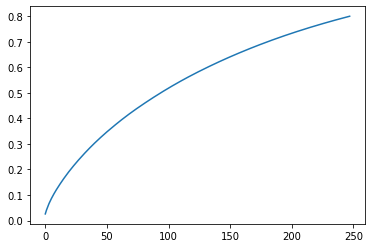

In [10]:
# PCA
pca = PCA(0.8)
pca.fit(X_train_scaled)


# Plotting how large part of variance explained
explained = pca.explained_variance_ratio_.cumsum()
plt.plot(np.arange(len(explained)),explained)
plt.show()

X_train_pca, X_test_pca = pca.transform(X_train_scaled), pca.transform(X_test_scaled)

In [11]:
prediction_table = test_different_models(X_train_pca, X_test_pca, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_basecase_pca = scores.copy()
scores_basecase_pca.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_basecase_pca.rename(columns={'Mean squared error':'MSE basecase with PCA'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:20 Time:  0:00:20


Model,Explained variance,Mean squared error,R2 score
DecisionTreeRegressor,-0.054,0.41,-0.055
LinearRegression,0.11,0.39,-0.015
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
AdaBoostRegressor,0.14,0.36,0.082
SVM regressor - RBF kernel,0.13,0.34,0.12
RandomForestRegressor,0.17,0.32,0.17


### Non-PCA testing done on data with date split to new columns

In [12]:
# Splitting date column into separate columns
joined_df["month"] = joined_df['random_reviews_date'].map(lambda x: x.month)
joined_df["year"] = joined_df['random_reviews_date'].map(lambda x: x.year)
joined_df["day"] = joined_df['random_reviews_date'].map(lambda x: x.day)
joined_df["weekday"] = joined_df['random_reviews_date'].map(lambda x: x.weekday())
joined_df["hour"] = joined_df['random_reviews_date'].map(lambda x: x.hour)

# Checking number of NaN - no columns with NaN
s = joined_df.isna().sum()
print("Columns with non-zero number of nan: ",s[s != 0])

Columns with non-zero number of nan:  Series([], dtype: int64)


In [13]:
# Splitting to training and test and separating predictors from labels
features, labels = joined_df.drop(['random_reviews_useful','random_reviews_business_id','random_reviews_review_id','random_reviews_text','random_reviews_user_id','random_reviews_date'], axis=1), joined_df['random_reviews_useful']






In [14]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))

# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)


# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)



prediction_table = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_datesplit = scores.copy()
scores_datesplit.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_datesplit.rename(columns={'Mean squared error':'MSE date column split'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

Returns X_train, X_test, y_train, y_test
X_train.shape: (800, 1085), y_train.shape: (800, 1)
N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:13 Time:  0:00:13


Model,Explained variance,Mean squared error,R2 score
LinearRegression,-0.11,0.51,-0.3
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
SVM regressor - RBF kernel,0.18,0.32,0.18
DecisionTreeRegressor,0.38,0.24,0.38
RandomForestRegressor,0.59,0.16,0.59
AdaBoostRegressor,0.62,0.15,0.6


### Further testing - splitting cyclical data into sin and cos time

In [15]:
joined_df["seconds"] = joined_df['random_reviews_date'].map(lambda x: x.hour * 60 * 60 + x.minute * 60 + x.second)

# Splitting seconds into 24h sin and cos time
# Taken from https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
seconds_in_day = 24*60*60
joined_df['sin_time'] = np.sin(2*np.pi*joined_df["seconds"]/seconds_in_day)
joined_df['cos_time'] = np.cos(2*np.pi*joined_df["seconds"]/seconds_in_day)

weekdays_in_week = 7
joined_df['sin_weekday'] = np.sin(2*np.pi*joined_df["weekday"]/weekdays_in_week)
joined_df['cos_weekday'] = np.cos(2*np.pi*joined_df["weekday"]/weekdays_in_week)

months_in_year = 12
joined_df['sin_month'] = np.sin(2*np.pi*joined_df["month"]/months_in_year)
joined_df['cos_month'] = np.cos(2*np.pi*joined_df["month"]/months_in_year)


# Checking number of NaN - no columns with NaN
s = joined_df.isna().sum()
print("Columns with non-zero number of nan: ",s[s != 0])

Columns with non-zero number of nan:  Series([], dtype: int64)


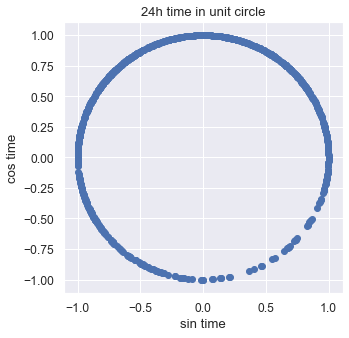

In [19]:
#Plotting sin and cos time
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('sin time')
ax.set_ylabel('cos time')
ax.set_title('24h time in unit circle')
ax.scatter(joined_df['sin_time'],joined_df['cos_time'])

plt.show()

In [16]:
# Splitting to training and test and separating predictors from labels
features, labels = joined_df.drop(['random_reviews_useful','random_reviews_business_id','random_reviews_review_id','random_reviews_text','random_reviews_user_id','random_reviews_date','seconds','month','weekday'], axis=1), joined_df['random_reviews_useful']






In [17]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))

# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)



prediction_table = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)



scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_sin_cos_time = scores.copy()
scores_sin_cos_time.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_sin_cos_time.rename(columns={'Mean squared error':'MSE sin/cos-time'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
X_train.shape: (800, 1089), y_train.shape: (800, 1)
C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


Model,Explained variance,Mean squared error,R2 score
LinearRegression,-0.099,0.51,-0.3
SVM regressor - linear,0,0.39,-0.014
--Average value from training data--,0,0.39,-0.014
SVM regressor - RBF kernel,0.19,0.32,0.18
DecisionTreeRegressor,0.35,0.25,0.35
RandomForestRegressor,0.6,0.16,0.6
AdaBoostRegressor,0.63,0.15,0.62


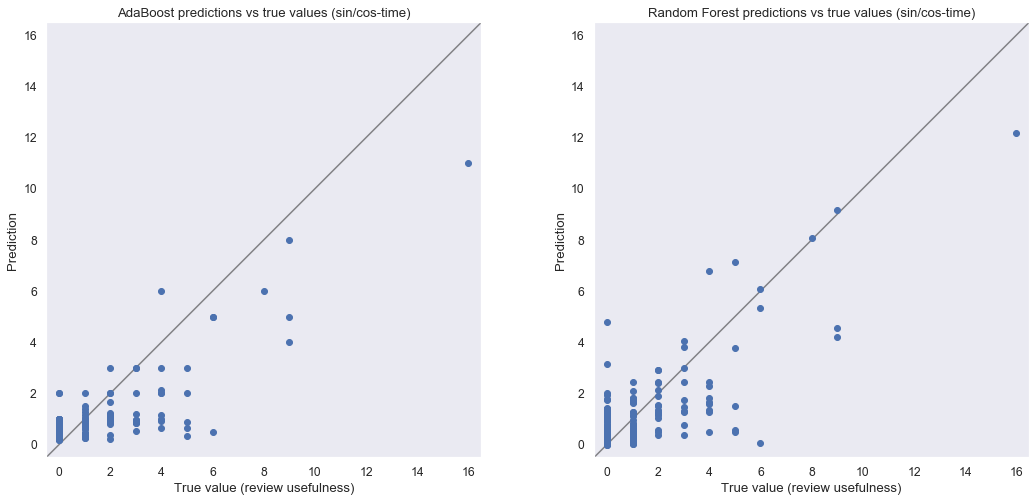

In [18]:
sns.set(font_scale=1.1)

# Plotting scatter, predicted and true values for Random Forest and AdaBoost
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,8)
ax1.set_xlabel('True value (review usefulness)')
ax1.set_ylabel('Prediction')
ax1.set_title('AdaBoost predictions vs true values (sin/cos-time)')
ax1.plot([-0.5,16.5],[-0.5,16.5], 'k-', alpha=0.5, zorder=0)
ax1.set_aspect('equal')
ax1.set_ylim(-0.5,16.5)
ax1.set_xlim(-0.5,16.5)
ax1.grid()
ax1.scatter(scaler_y.inverse_transform(prediction_table['True value']),scaler_y.inverse_transform(prediction_table['AdaBoostRegressor']))




ax2.set_xlabel('True value (review usefulness)')
ax2.set_ylabel('Prediction')
ax2.set_title('Random Forest predictions vs true values (sin/cos-time)')
ax2.plot([-0.5,16.5],[-0.5,16.5], 'k-', alpha=0.5, zorder=0)
ax2.set_aspect('equal')
ax2.set_ylim(-0.5,16.5)
ax2.set_xlim(-0.5,16.5)
ax2.grid()
ax2.scatter(scaler_y.inverse_transform(prediction_table['True value']),scaler_y.inverse_transform(prediction_table['RandomForestRegressor']))


plt.show()

### Testing for overfitting - error in train set - to be compared with train data scores

In [20]:
prediction_table = test_different_models(X_train_scaled, X_train_scaled, y_train_scaled.flatten(), y_train_scaled.flatten(), modelsToTest)
# Adding dummy guess to prediction table
prediction_table["--Average value from training data--"] = np.mean(y_train_scaled)
# prediction_table["Train Y Median"] = np.median(y_train_scaled)


scores = metrics_regression(prediction_table)

scores = scores.sort_values(by=['Mean squared error'], ascending=False)

scores_sin_cos_train = scores.copy()
scores_sin_cos_train.drop(['R2 score','Explained variance'],axis=1, inplace=True)
scores_sin_cos_train.rename(columns={'Mean squared error':'MSE sin/cos-time training'}, inplace=True)

print_scoretable(scores, columns=['Explained variance','Mean squared error','R2 score'])

N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\MattiH\.conda\envs\DS_project\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100% (6 of 6) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


Model,Explained variance,Mean squared error,R2 score
SVM regressor - linear,0,1,0
--Average value from training data--,0,1,0
LinearRegression,0.33,0.68,0.32
SVM regressor - RBF kernel,0.45,0.56,0.44
DecisionTreeRegressor,0.9,0.1,0.9
RandomForestRegressor,0.92,0.079,0.92
AdaBoostRegressor,0.99,0.013,0.99



### Plotting training and testing error - adaboost and decision tree number of trees
Done on sin and cost time dataset

In [21]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split_as_requested(X, y)

y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)

print("X_train.shape: {}, y_train.shape: {}".format(X_train.shape, y_train.shape))

# Converting data to float64 from int64 for StandardScaler
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

# Scaling data
scaler_X, scaler_y = StandardScaler(), StandardScaler()
scaler_X.fit(X_train), scaler_y.fit(y_train)
X_train_scaled, y_train_scaled = scaler_X.transform(X_train), scaler_y.transform(y_train)
X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)

results_df = pd.DataFrame()

for number_trees in range(1,50,2):

  modelsToTest=[
    ("DecisionTreeRegressor", DecisionTreeRegressor(max_depth=number_trees,min_samples_split=10)),
    ("AdaBoostRegressor", AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=number_trees), n_estimators=50))
    ]

  # MSE from test
  prediction_table_test = test_different_models(X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), modelsToTest)
  scores_test = metrics_regression(prediction_table_test)
  scores_test = scores_test.sort_values(by=['Mean squared error'], ascending=False)
  scores_test.drop(['R2 score','Explained variance'],axis=1,inplace=True)
  scores_test["Number of trees"] = number_trees
  scores_test["Train or test"] = "Test"

  # MSE from train
  prediction_table_train = test_different_models(X_train_scaled, X_train_scaled, y_train_scaled.flatten(), y_train_scaled.flatten(), modelsToTest)
  scores_train = metrics_regression(prediction_table_train)
  scores_train = scores_train.sort_values(by=['Mean squared error'], ascending=False)
  scores_train.drop(['R2 score','Explained variance'],axis=1,inplace=True)
  scores_train["Number of trees"] = number_trees
  scores_train["Train or test"] = "Train"

  frames = [results_df, scores_test, scores_train]

  results_df = pd.concat(frames)



N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--Returns X_train, X_test, y_train, y_test
X_train.shape: (800, 1089), y_train.shape: (800, 1)
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (2 of 2) |#############

In [22]:
results_df.head()

,Model,Mean squared error,Number of trees,Train or test
1,AdaBoostRegressor,5.991452,1,Test
0,DecisionTreeRegressor,0.258295,1,Test
1,AdaBoostRegressor,6.626640,1,Train
0,DecisionTreeRegressor,0.685226,1,Train
1,AdaBoostRegressor,0.850483,3,Test


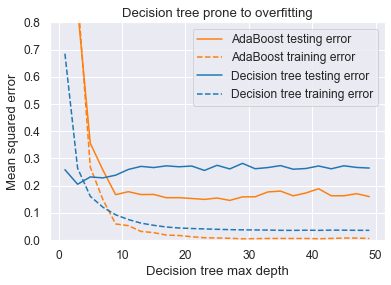

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#fig.set_size(10,10)

ax.set_xlabel('Decision tree max depth')
ax.set_ylabel('Mean squared error')
ax.set_title('Decision tree prone to overfitting')

ax.plot(results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Test'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Test'), 'Mean squared error' ] ,
        label='AdaBoost testing error', color='#FF7F0E')
ax.plot(results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Train'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'AdaBoostRegressor') & (results_df['Train or test'] == 'Train'), 'Mean squared error' ] ,
        label='AdaBoost training error', linestyle='dashed',color='#FF7F0E')

ax.plot(results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Test'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Test'), 'Mean squared error' ] ,
        label='Decision tree testing error', color='#1F77B4')

ax.plot(results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Train'), 'Number of trees'],results_df.loc[(results_df['Model'] == 'DecisionTreeRegressor') & (results_df['Train or test'] == 'Train'), 'Mean squared error' ] ,
        label='Decision tree training error', linestyle='dashed', color='#1F77B4')

plt.ylim(0,0.8)

plt.legend()

plt.show()

### Joining results from different datasets

In [24]:
all_results = scores_basecase.join([scores_basecase_pca.drop(['Model'],axis=1),
                                    scores_datesplit.drop(['Model'],axis=1),scores_sin_cos_time.drop(['Model'],axis=1),
                                    scores_sin_cos_train.drop(['Model'],axis=1)])
all_results = all_results.sort_values(by=['MSE basecase'], ascending=True)
print_scoretable(all_results, columns=all_results.columns[1:])

Model,MSE basecase,MSE basecase with PCA,MSE date column split,MSE sin/cos-time,MSE sin/cos-time training
AdaBoostRegressor,0.14,0.36,0.15,0.15,0.013
RandomForestRegressor,0.17,0.32,0.16,0.16,0.079
DecisionTreeRegressor,0.24,0.41,0.24,0.25,0.1
SVM regressor - RBF kernel,0.32,0.34,0.32,0.32,0.56
SVM regressor - linear,0.39,0.39,0.39,0.39,1
--Average value from training data--,0.39,0.39,0.39,0.39,1
LinearRegression,0.55,0.39,0.51,0.51,0.68


### Random forest feature importancies and one tree

In [25]:
# Instantiating the model
rf = RandomForestRegressor(n_estimators=100)
model = rf.fit(X_train_scaled, y_train_scaled.flatten())



In [26]:

#Visualising one tree
feature_list = features.columns

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list,  rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


from IPython.display import Image
Image("tree.png", width=5000,height=5000)